In [73]:
!pip -q install torch_geometric

In [83]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from torch_geometric.nn import MessagePassing
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import add_self_loops, degree, to_undirected
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import maximum_bipartite_matching
from tqdm import tqdm

In [84]:
def glorot(tensor):
    if tensor is not None:
        torch.nn.init.xavier_uniform_(tensor)

def zeros(tensor):
    if tensor is not None:
        torch.nn.init.zeros_(tensor)



def create_similarity_graph(x, threshold=0.5):
    sim_matrix = cosine_similarity(x.cpu().numpy())

    sim_matrix[sim_matrix < threshold] = 0

    rows, cols = np.where(sim_matrix > 0)
    edge_index = torch.tensor([rows, cols], dtype=torch.long)


    edge_index = to_undirected(edge_index)

    return edge_index

def create_b_matching_graph(x, b=5):

    sim_matrix = cosine_similarity(x.cpu().numpy())


    n = sim_matrix.shape[0]
    rows, cols = [], []
    for i in range(n):

        top_b = np.argsort(sim_matrix[i])[-b:]
        rows.extend([i] * b)
        cols.extend(top_b)

    data = np.ones(len(rows))
    sparse_matrix = csr_matrix((data, (rows, cols)), shape=(n, n))


    matching = maximum_bipartite_matching(sparse_matrix)


    edge_index = torch.tensor([[i, matching[i]] for i in range(n) if matching[i] >= 0]).t()


    edge_index = to_undirected(edge_index)

    return edge_index

In [85]:
class MultiGraphConvolution(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(MultiGraphConvolution, self).__init__(aggr='add')
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.weight1 = torch.nn.Parameter(torch.Tensor(in_channels, out_channels))
        self.weight2 = torch.nn.Parameter(torch.Tensor(in_channels, out_channels))
        self.weight3 = torch.nn.Parameter(torch.Tensor(in_channels, out_channels))


        self.attention_mlp = torch.nn.Sequential(
            torch.nn.Linear(out_channels, 6),
            torch.nn.ReLU(),
            torch.nn.Linear(6, 3),
            torch.nn.ReLU(),
            torch.nn.Linear(3, 1)
        )

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight1)
        glorot(self.weight2)
        glorot(self.weight3)
        for layer in self.attention_mlp:
            if isinstance(layer, torch.nn.Linear):
                glorot(layer.weight)
                zeros(layer.bias)

    def forward(self, x, edge_index1, edge_index2, edge_index3):
        x = F.dropout(x, p=0.5, training=self.training)

        edge_index1, _ = add_self_loops(edge_index1, num_nodes=x.size(0))
        edge_index2, _ = add_self_loops(edge_index2, num_nodes=x.size(0))
        edge_index3, _ = add_self_loops(edge_index3, num_nodes=x.size(0))

        row1, col1 = edge_index1
        row2, col2 = edge_index2
        row3, col3 = edge_index3

        deg1 = degree(row1, x.size(0), dtype=x.dtype)
        deg2 = degree(row2, x.size(0), dtype=x.dtype)
        deg3 = degree(row3, x.size(0), dtype=x.dtype)

        norm1 = deg1.pow(-0.5)
        norm2 = deg2.pow(-0.5)
        norm3 = deg3.pow(-0.5)

        norm1 = norm1[row1] * norm1[col1]
        norm2 = norm2[row2] * norm2[col2]
        norm3 = norm3[row3] * norm3[col3]

        x1 = torch.matmul(x, self.weight1)
        x2 = torch.matmul(x, self.weight2)
        x3 = torch.matmul(x, self.weight3)

        out1 = self.propagate(edge_index1, x=x1, norm=norm1)
        out2 = self.propagate(edge_index2, x=x2, norm=norm2)
        out3 = self.propagate(edge_index3, x=x3, norm=norm3)


        gap1 = self.graph_gap(out1, edge_index1)
        gap2 = self.graph_gap(out2, edge_index2)
        gap3 = self.graph_gap(out3, edge_index3)


        att1 = self.attention_mlp(gap1)
        att2 = self.attention_mlp(gap2)
        att3 = self.attention_mlp(gap3)

        alpha = F.softmax(torch.cat([att1, att2, att3]), dim=0)

        out = alpha[0] * out1 + alpha[1] * out2 + alpha[2] * out3

        return out

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        return aggr_out

    def graph_gap(self, x, edge_index):
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv = deg.pow(-1)
        deg_inv[deg_inv == float('inf')] = 0


        neighbor_sum = torch.zeros_like(x)
        neighbor_sum.index_add_(0, row, x[col])


        x_avg = deg_inv.view(-1, 1) * neighbor_sum


        return torch.mean(x_avg, dim=0)

class MAGCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(MAGCN, self).__init__()
        self.conv1 = MultiGraphConvolution(num_node_features, 16)
        self.conv2 = MultiGraphConvolution(16, num_classes)

    def forward(self, x, edge_index1, edge_index2, edge_index3):
        x = self.conv1(x, edge_index1, edge_index2, edge_index3)
        x = F.relu(x)
        x = self.conv2(x, edge_index1, edge_index2, edge_index3)
        return F.log_softmax(x, dim=1)

In [86]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, edge_index1, edge_index2, edge_index3)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits = model(data.x, edge_index1, edge_index2, edge_index3)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

Training Progress:   1%|          | 10/1000 [00:00<00:21, 46.04it/s]

Epoch: 001, Loss: 1.9458, Train Acc: 0.4929, Val Acc: 0.4180, Test Acc: 0.4160


Training Progress:  10%|█         | 105/1000 [00:04<00:36, 24.31it/s]

Epoch: 101, Loss: 0.9868, Train Acc: 0.9429, Val Acc: 0.7740, Test Acc: 0.7920


Training Progress:  21%|██        | 208/1000 [00:06<00:16, 46.83it/s]

Epoch: 201, Loss: 0.4727, Train Acc: 0.9857, Val Acc: 0.7880, Test Acc: 0.8030


Training Progress:  30%|███       | 304/1000 [00:09<00:26, 26.41it/s]

Epoch: 301, Loss: 0.4469, Train Acc: 0.9857, Val Acc: 0.7860, Test Acc: 0.8090


Training Progress:  41%|████      | 409/1000 [00:11<00:12, 47.15it/s]

Epoch: 401, Loss: 0.3800, Train Acc: 0.9929, Val Acc: 0.7880, Test Acc: 0.8060


Training Progress:  50%|█████     | 504/1000 [00:15<00:27, 17.72it/s]

Epoch: 501, Loss: 0.3663, Train Acc: 1.0000, Val Acc: 0.7920, Test Acc: 0.8140


Training Progress:  61%|██████    | 609/1000 [00:19<00:08, 44.88it/s]

Epoch: 601, Loss: 0.3676, Train Acc: 1.0000, Val Acc: 0.7960, Test Acc: 0.8170


Training Progress:  70%|███████   | 704/1000 [00:23<00:15, 18.64it/s]

Epoch: 701, Loss: 0.4383, Train Acc: 1.0000, Val Acc: 0.7940, Test Acc: 0.8200


Training Progress:  80%|████████  | 804/1000 [00:26<00:07, 26.69it/s]

Epoch: 801, Loss: 0.3005, Train Acc: 1.0000, Val Acc: 0.7880, Test Acc: 0.8160


Training Progress:  90%|█████████ | 902/1000 [00:30<00:03, 24.61it/s]

Epoch: 901, Loss: 0.3965, Train Acc: 1.0000, Val Acc: 0.7940, Test Acc: 0.8170


Training Progress: 100%|██████████| 1000/1000 [00:33<00:00, 29.70it/s]


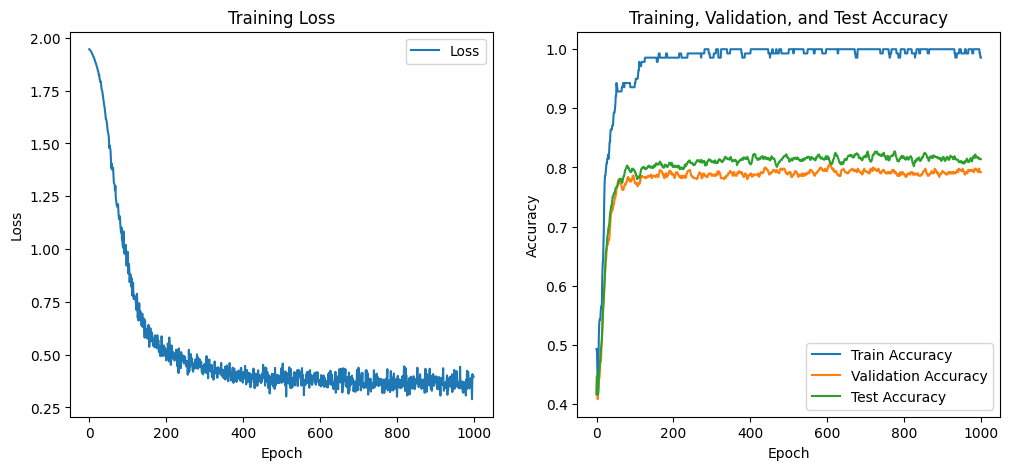

In [88]:
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())  # 'Cora' or 'Pubmed' or 'Citeseer'
data = dataset[0]


edge_index1 = data.edge_index
edge_index2 = create_similarity_graph(data.x)
edge_index3 = create_b_matching_graph(data.x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MAGCN(dataset.num_features, dataset.num_classes).to(device)
data = data.to(device)
edge_index1 = edge_index1.to(device)
edge_index2 = edge_index1.to(device)
edge_index3 = edge_index1.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)



losses = []
train_accs = []
val_accs = []
test_accs = []


epochs = 1000
for epoch in tqdm(range(epochs), desc="Training Progress"):
    loss = train()
    train_acc, val_acc, test_acc = test()


    losses.append(loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    if epoch % 100 == 0:
        print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accs, label='Train Accuracy')
plt.plot(range(epochs), val_accs, label='Validation Accuracy')
plt.plot(range(epochs), test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()

plt.show()

Training Progress:   1%|          | 10/1000 [00:00<00:20, 47.15it/s]

Epoch: 001, Loss: 1.7917, Train Acc: 0.6583, Val Acc: 0.4760, Test Acc: 0.4710


Training Progress:  10%|█         | 103/1000 [00:02<00:24, 37.33it/s]

Epoch: 101, Loss: 1.0438, Train Acc: 0.9250, Val Acc: 0.6640, Test Acc: 0.6710


Training Progress:  21%|██        | 209/1000 [00:06<00:22, 35.47it/s]

Epoch: 201, Loss: 0.7477, Train Acc: 0.9500, Val Acc: 0.7040, Test Acc: 0.7100


Training Progress:  31%|███       | 309/1000 [00:08<00:15, 45.99it/s]

Epoch: 301, Loss: 0.6350, Train Acc: 0.9750, Val Acc: 0.7060, Test Acc: 0.7130


Training Progress:  41%|████      | 410/1000 [00:10<00:12, 45.57it/s]

Epoch: 401, Loss: 0.6605, Train Acc: 0.9750, Val Acc: 0.7040, Test Acc: 0.7130


Training Progress:  51%|█████     | 506/1000 [00:12<00:10, 45.62it/s]

Epoch: 501, Loss: 0.6520, Train Acc: 0.9667, Val Acc: 0.7080, Test Acc: 0.7120


Training Progress:  60%|██████    | 604/1000 [00:15<00:17, 22.78it/s]

Epoch: 601, Loss: 0.6116, Train Acc: 0.9583, Val Acc: 0.7220, Test Acc: 0.7130


Training Progress:  71%|███████   | 708/1000 [00:19<00:06, 45.50it/s]

Epoch: 701, Loss: 0.6290, Train Acc: 0.9583, Val Acc: 0.7200, Test Acc: 0.7110


Training Progress:  81%|████████  | 809/1000 [00:21<00:04, 46.21it/s]

Epoch: 801, Loss: 0.6345, Train Acc: 0.9750, Val Acc: 0.7180, Test Acc: 0.7190


Training Progress:  91%|█████████ | 910/1000 [00:23<00:01, 47.04it/s]

Epoch: 901, Loss: 0.6180, Train Acc: 0.9750, Val Acc: 0.7020, Test Acc: 0.7020


Training Progress: 100%|██████████| 1000/1000 [00:26<00:00, 37.72it/s]


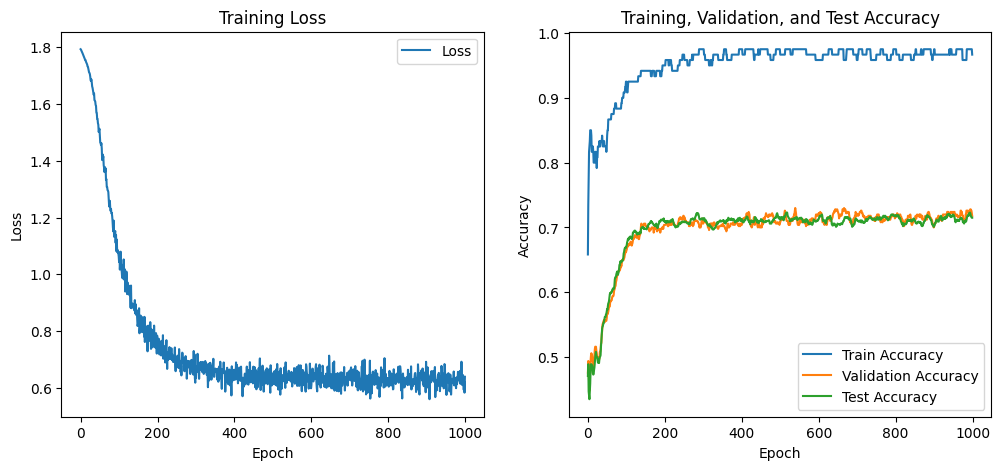

In [89]:
dataset = Planetoid(root='/tmp/Citeseer', name='Citeseer', transform=NormalizeFeatures())  # 'Cora' or 'Pubmed' or 'Citeseer'
data = dataset[0]


edge_index1 = data.edge_index
edge_index2 = create_similarity_graph(data.x)
edge_index3 = create_b_matching_graph(data.x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MAGCN(dataset.num_features, dataset.num_classes).to(device)
data = data.to(device)
edge_index1 = edge_index1.to(device)
edge_index2 = edge_index1.to(device)
edge_index3 = edge_index1.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)



losses = []
train_accs = []
val_accs = []
test_accs = []


epochs = 1000
for epoch in tqdm(range(epochs), desc="Training Progress"):
    loss = train()
    train_acc, val_acc, test_acc = test()


    losses.append(loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    if epoch % 100 == 0:
        print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accs, label='Train Accuracy')
plt.plot(range(epochs), val_accs, label='Validation Accuracy')
plt.plot(range(epochs), test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()

plt.show()

Training Progress:   1%|          | 10/1000 [00:00<00:22, 44.36it/s]

Epoch: 001, Loss: 1.0989, Train Acc: 0.7667, Val Acc: 0.6400, Test Acc: 0.6630


Training Progress:  11%|█         | 106/1000 [00:02<00:23, 38.09it/s]

Epoch: 101, Loss: 0.4209, Train Acc: 0.9667, Val Acc: 0.7840, Test Acc: 0.7790


Training Progress:  21%|██        | 207/1000 [00:05<00:17, 45.99it/s]

Epoch: 201, Loss: 0.3226, Train Acc: 0.9833, Val Acc: 0.7980, Test Acc: 0.7940


Training Progress:  31%|███       | 310/1000 [00:07<00:14, 47.60it/s]

Epoch: 301, Loss: 0.2944, Train Acc: 1.0000, Val Acc: 0.7960, Test Acc: 0.7950


Training Progress:  41%|████      | 410/1000 [00:09<00:12, 46.42it/s]

Epoch: 401, Loss: 0.2146, Train Acc: 0.9833, Val Acc: 0.8020, Test Acc: 0.7940


Training Progress:  51%|█████     | 510/1000 [00:11<00:10, 46.64it/s]

Epoch: 501, Loss: 0.2104, Train Acc: 1.0000, Val Acc: 0.8020, Test Acc: 0.7890


Training Progress:  61%|██████    | 606/1000 [00:13<00:08, 46.54it/s]

Epoch: 601, Loss: 0.2214, Train Acc: 0.9833, Val Acc: 0.7960, Test Acc: 0.7910


Training Progress:  71%|███████   | 706/1000 [00:16<00:08, 33.54it/s]

Epoch: 701, Loss: 0.2409, Train Acc: 1.0000, Val Acc: 0.7920, Test Acc: 0.7940


Training Progress:  80%|████████  | 805/1000 [00:18<00:04, 44.98it/s]

Epoch: 801, Loss: 0.2083, Train Acc: 0.9833, Val Acc: 0.8000, Test Acc: 0.7900


Training Progress:  91%|█████████ | 910/1000 [00:21<00:01, 45.57it/s]

Epoch: 901, Loss: 0.2119, Train Acc: 0.9833, Val Acc: 0.7980, Test Acc: 0.7950


Training Progress: 100%|██████████| 1000/1000 [00:23<00:00, 43.33it/s]


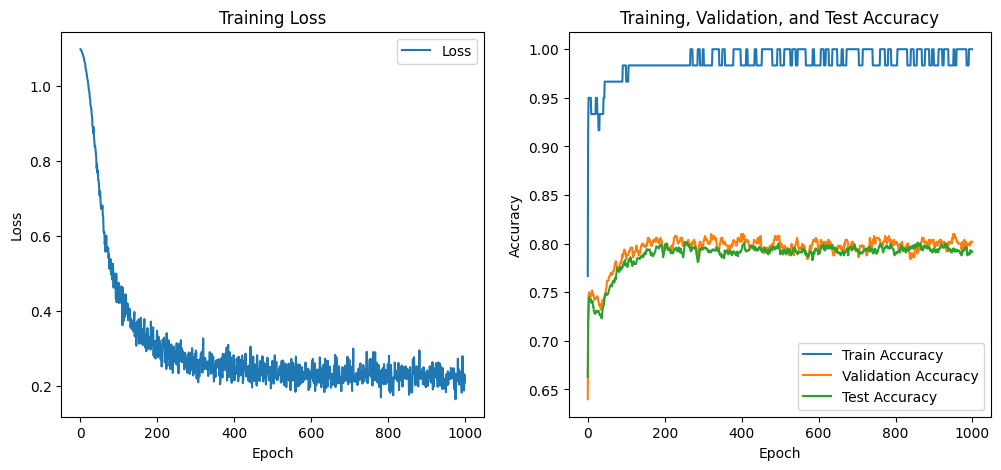

In [90]:
dataset = Planetoid(root='/tmp/Pubmed', name='Pubmed', transform=NormalizeFeatures())  # 'Cora' or 'Pubmed' or 'Citeseer'
data = dataset[0]


edge_index1 = data.edge_index
edge_index2 = create_similarity_graph(data.x)
edge_index3 = create_b_matching_graph(data.x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MAGCN(dataset.num_features, dataset.num_classes).to(device)
data = data.to(device)
edge_index1 = edge_index1.to(device)
edge_index2 = edge_index1.to(device)
edge_index3 = edge_index1.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)



losses = []
train_accs = []
val_accs = []
test_accs = []


epochs = 1000
for epoch in tqdm(range(epochs), desc="Training Progress"):
    loss = train()
    train_acc, val_acc, test_acc = test()


    losses.append(loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    if epoch % 100 == 0:
        print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accs, label='Train Accuracy')
plt.plot(range(epochs), val_accs, label='Validation Accuracy')
plt.plot(range(epochs), test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()

plt.show()